In [2]:
import pandas as pd
import sys
sys.path.append('../src')
from kimi_api import client
from tqdm import tqdm

In [3]:
df = pd.read_csv('../data/协作表 - V1 - 待审查.csv')
df = df[['自我肯定语-V1', '字数']]

In [ ]:
df = pd.read_csv('../data/协作表 - 上线句子清单.csv')
df = df[['知乎资料', '来源', '最终结果', '权重', '合集']]
df.columns

Index(['知乎资料', '来源', '最终结果', '权重', '合集', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   自我肯定语-V1  1900 non-null   object
 1   字数        1900 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.8+ KB


In [15]:
# 随机选100条
df = df.sample(100)

In [11]:
role_prompt = """
你是一个情感分析专家，负责对句子进行四个维度的标注。请务必全面考虑句子的语义，确保每个可能的选项都被评估，避免漏选。

有开心就要有很好，有很好就要有开心
提到社交、联系就要有人际交往

1. 合集（只能在[情感疗愈 自信 平和心境 治愈之旅 人际交往 自我关怀 个人成长 成为英雄]中选一个，不要出现其余的内容）
   根据句子的主要语义与各个类别的特征进行比对，将其分类到最合适的一类中。
   选项：句子特征
   - 情感疗愈: 语义涉及情感修复、亲密关系或情感联结，即使未直接提及“情感”或“亲密关系”。
   - 自信: 语义涉及自我肯定、力量感或自我认知的提升，即使未直接提及“我能”或类似词语。
   - 平和心境: 语义涉及情绪调节、内心安宁或对现状的满足感，即使未直接提及“平和”、“安宁”或“感恩”。
   - 治愈之旅: 语义涉及自我接纳、自我宽慰或内在疗愈，即使未直接提及“安慰”或“接纳”。
   - 人际交往: 语义涉及与他人互动、沟通或关系建立，即使未直接提及“他人”或“沟通”，“联系”。
   - 自我关怀: 语义涉及自我爱护、身心健康或生活平衡，即使未直接提及“爱自己”、“健康”或“休息”。
   - 个人成长: 语义涉及自我提升、事业发展或学习创造，即使未直接提及“成长”、“工作”或“学习”。
   - 成为英雄: 语义涉及勇敢行动、宽恕他人、追求理想，付出、牺牲。即使未直接提及“勇气”、“原谅”或“理想”。

2. 感情状况（只在[正在恋爱 处在一段艰难的亲密关系中 快乐地单身着 单身但准备好了开始新的恋情 最近刚分手 有点辛苦的暗恋]这些词语中多选，尽量多选，不要出现其余的内容）
   这个句子适合推送给哪些感情状态的用户？请务必全面评估句子的语义，确保每个可能的选项都被考虑。
   选项：
   - 正在恋爱: 语义涉及甜蜜、稳定、幸福的亲密关系，或对伴侣的积极情感表达。
   - 处在一段艰难的亲密关系中: 语义涉及关系中的矛盾、困惑、挣扎，或对关系改善的渴望。
     - 排除：个人成长、成为英雄合集的句子。
   - 快乐地单身着: 语义涉及享受独处、自我成长、独立自主，或对单身状态的积极态度。
   - 单身但准备好了开始新的恋情: 语义涉及对爱情的期待、开放心态，或为新的关系做准备的积极情绪。
   - 最近刚分手: 语义涉及情感失落、疗愈、反思，或对过去关系的释怀。
     - 排除：个人成长、成为英雄合集的句子。
   - 有点辛苦的暗恋: 避免离开、分离，最好提及人际交往合集中涉及勇气的句子，疗愈、鼓励、尤其是人际关系上的主动
     - 排除：个人成长、成为英雄合集的句子。

   **注意**：如果一个句子同时适合多个感情状态，请务必全部选择。例如：
   - 句子：“爱自己是一切美好的开始。”  
     - 适合：**快乐地单身着**（享受独处）、**最近刚分手**（疗愈）、**单身但准备好了开始新的恋情**（积极心态）。

3. 最近的感觉（在[开心 很好 一般 不好 糟糕]多选, 【开心 很好】，【不好 糟糕】绑定同时出现或不出现，不要出现额外的标签）
   选项：句子特征
   - 开心: 语义涉及自信、力量感、成就感（自信合集、个人成长合集）。
     - 排除：治愈之旅、平和心境合集的句子。
   - 很好: 语义涉及积极情绪、满足感或幸福感。
     - 排除：治愈之旅合集的句子。
   - 一般: 语义涉及中性情绪或日常状态，包括自信。
     - 排除：成为英雄合集的句子。
   - 不好: 语义涉及需要安慰、支持或情绪调节（治愈之旅合集、平和心境合集）,不排除自信。
     - 排除：个人成长、成为英雄合集的句子。
   - 糟糕: 语义涉及强烈的情感低落、痛苦或无助感（治愈之旅合集、平和心境合集）。
     - 排除：个人成长、成为英雄合集的句子。

   **注意**：如果一个句子同时适合多个感觉，请务必全部选择。例如：
   - 句子：“最近总是觉得很累，需要好好休息一下。”  
     - 适合：**不好**（需要安慰）、**糟糕**（强烈情感低落）。

4. 什么让你有这种感觉（多选）
   选项：句子特征
   - 家庭: 包含“家”和人际关系合集的句子。
   - 朋友: 人际关系合集的句子。
   - 工作: 个人成长合集中提及事业、工作的句子。
   - 健康: 自我关怀合集的句子。
   - 感情: 提及“爱”、“情感”、“亲密关系”
   - 学业: 个人成长合集中提及学习的句子。
     - 排除：工作、事业相关的句子。
   - 自己: 自信、自我关怀合集的句子

   **注意**：如果一个句子同时涉及多个原因，请务必全部选择。例如：
   - 句子：“最近工作压力大，但朋友的支持让我感到温暖。”  
     - 适合：**工作**（压力）、**朋友**（支持）。

例子：
我相信即使独自一人，我也能过得很充实。,自信,['快乐地单身着'],['开心','很好'],['自己']
我选择爱护自己，珍视生命的每一步。,自我关怀,['快乐地单身着','处在一段艰难的亲密关系中', '单身但准备好了开始新的恋情','最近刚分手','有点辛苦的暗恋'],['开心','很好','一般','不好','糟糕'],['自己','感情','朋友','家庭','工作','学业','健康']
我的话语有力量，我选择积极地使用它。,人际交往,['快乐地单身着','处在一段艰难的亲密关系中', '单身但准备好了开始新的恋情','最近刚分手','有点辛苦的暗恋'],['开心','很好','一般','不好','糟糕'],['自己','感情','朋友','家庭','工作']

请根据提供的句子特征进行标注，用以匹配其适用的场景，并返回JSON格式的结果。以下是返回结果的JSON示例：

{
  "合集": "情感疗愈",
  "感情状况": ["正在恋爱", "快乐地单身着"],
  "最近的感觉": ["开心", "很好"],
  "什么让你有这种感觉": ["家庭", "朋友"]
}

**重要提示**：请务必全面评估句子的语义，确保每个可能的选项都被考虑，避免漏选。

1. 社交合作、他人、感情：根据语义内容，归类到人际交往合集。
正在恋爱：排除新的感情
"""

In [18]:

role_prompt="""
你是一个情感分析专家，负责对句子进行四个维度的标注。请务必全面考虑句子的语义，确保每个可能的选项都被评估，避免漏选。

1. 合集（只能在[情感疗愈 自信 平和心境 治愈之旅 人际交往 自我关怀 个人成长 成为英雄]中选一个，不要出现其余的内容）
   根据句子的主要语义与各个类别的特征进行比对，将其分类到最合适的一类中。
   选项：句子特征
   - 情感疗愈: 语义涉及情感修复、亲密关系或情感联结，即使未直接提及“情感”或“亲密关系”。
   - 自信: 语义涉及自我肯定、力量感或自我认知的提升，即使未直接提及“我能”或类似词语。
   - 平和心境: 语义涉及情绪调节、内心安宁或对现状的满足感，即使未直接提及“平和”、“安宁”或“感恩”。
   - 治愈之旅: 语义涉及自我接纳、自我宽慰或内在疗愈，即使未直接提及“安慰”或“接纳”。
   - 人际交往: 语义涉及与他人互动、沟通或关系建立，即使未直接提及“他人”或“沟通”，“联系”。
   - 自我关怀: 语义涉及自我爱护、身心健康或生活平衡，即使未直接提及“爱自己”、“健康”或“休息”。
   - 个人成长: 语义涉及自我提升、事业发展或学习创造，即使未直接提及“成长”、“工作”或“学习”。
   - 成为英雄: 语义涉及勇敢行动、宽恕他人、追求理想，付出、牺牲。即使未直接提及“勇气”、“原谅”或“理想”。

2. 感情状况（只在[正在恋爱 处在一段艰难的亲密关系中 快乐地单身着 单身但准备好了开始新的恋情 最近刚分手 有点辛苦的暗恋]这些词语中多选，尽量多选，不要出现其余的内容）
   这个句子适合推送给哪些感情状态的用户？请务必全面评估句子的语义，确保每个可能的选项都被考虑。
   选项：
   - 正在恋爱: 语义涉及甜蜜、稳定、幸福的亲密关系，或对伴侣的积极情感表达。
   - 处在一段艰难的亲密关系中: 语义涉及关系中的矛盾、困惑、挣扎，或对关系改善的渴望。
   - 快乐地单身着: 语义涉及享受独处、自我成长、独立自主，或对单身状态的积极态度。
   - 单身但准备好了开始新的恋情: 语义涉及对爱情的期待、开放心态，或为新的关系做准备的积极情绪。
   - 最近刚分手: 语义涉及情感失落、疗愈、反思，或对过去关系的释怀。
   - 有点辛苦的暗恋: 语义涉及对某人的暗恋，可能带有一定的情感负担或不确定性。

   **注意**：如果一个句子同时适合多个感情状态，请务必全部选择。例如：
   - 句子：“爱自己是一切美好的开始。”  
     - 适合：**快乐地单身着**（享受独处）、**最近刚分手**（疗愈）、**单身但准备好了开始新的恋情**（积极心态）。

3. 最近的感觉（在[开心 很好 一般 不好 糟糕]多选, 【开心 很好】，【不好 糟糕】绑定同时出现或不出现，不要出现额外的标签）
   选项：句子特征
   - 开心: 语义涉及自信、力量感、成就感（自信合集、个人成长合集）。
   - 很好: 语义涉及积极情绪、满足感或幸福感。
   - 一般: 语义涉及中性情绪或日常状态，包括自信。
   - 不好: 语义涉及需要安慰、支持或情绪调节（治愈之旅合集、平和心境合集）,不排除自信。
   - 糟糕: 语义涉及强烈的情感低落、痛苦或无助感（治愈之旅合集、平和心境合集）。

   **注意**：如果一个句子同时适合多个感觉，请务必全部选择。例如：
   - 句子：“最近总是觉得很累，需要好好休息一下。”  
     - 适合：**不好**（需要安慰）、**糟糕**（强烈情感低落）。

4. 什么让你有这种感觉（多选）
   选项：句子特征
   - 家庭: 包含“家”和人际关系合集的句子。
   - 朋友: 人际关系合集的句子。
   - 工作: 个人成长合集中提及事业、工作的句子。
   - 健康: 自我关怀合集的句子。
   - 感情: 提及“爱”、“情感”、“亲密关系”
   - 学业: 个人成长合集中提及学习的句子。
   - 自己: 自信、自我关怀合集的句子

   **注意**：如果一个句子同时涉及多个原因，请务必全部选择。例如：
   - 句子：“最近工作压力大，但朋友的支持让我感到温暖。”  
     - 适合：**工作**（压力）、**朋友**（支持）。

例子：
我相信即使独自一人，我也能过得很充实。,自信,['快乐地单身着'],['开心','很好'],['自己']
我选择爱护自己，珍视生命的每一步。,自我关怀,['快乐地单身着','处在一段艰难的亲密关系中', '单身但准备好了开始新的恋情','最近刚分手','有点辛苦的暗恋'],['开心','很好','一般','不好','糟糕'],['自己','感情','朋友','家庭','工作','学业','健康']
我的话语有力量，我选择积极地使用它。,人际交往,['快乐地单身着','处在一段艰难的亲密关系中', '单身但准备好了开始新的恋情','最近刚分手','有点辛苦的暗恋'],['开心','很好','一般','不好','糟糕'],['自己','感情','朋友','家庭','工作']

请根据提供的句子特征进行标注，用以匹配其适用的场景，并返回JSON格式的结果。以下是返回结果的JSON示例：

{
  "合集": "情感疗愈",
  "感情状况": ["正在恋爱", "快乐地单身着"],
  "最近的感觉": ["开心", "很好"],
  "什么让你有这种感觉": ["家庭", "朋友"]
}

**重要提示**：请务必全面评估句子的语义，确保每个可能的选项都被考虑，避免漏选。

1. 社交合作、他人、感情：根据语义内容，归类到人际交往合集。
正在恋爱：排除新的感情
"""

In [ ]:
for i in [正在恋爱 处在一段艰难的亲密关系中 快乐地单身着 单身但准备好了开始新的恋情 最近刚分手 有点辛苦的暗恋]:
    for j in [开心/很好,一般,不好/糟糕]:
        {sentence} 是否适合推荐给 感情状况为{i}的心情{j}的用户？

目前的结果有一些错误，具体如下：
1. 合集方面
示例,特征、参考、理由，合集
我正逐步走出自己的舒适区，与人建立联系。,与人建立联系,人际交往
我珍视每一次新的社交体验，它是成长的基石。
我乐于学习沟通技巧，不断进步。,沟通技巧
每次无助感来临，都是我成长的机会。,无助感,治愈之旅（用户生命力较低时的自我安慰，负面的描述,过去的经历、错误）

In [16]:
import json
def get_annotations(sentence):
    message = f"请对以下句子进行标注：{sentence}"
    messages = [
        {"role": "system", "content": role_prompt},
        {"role": "user", "content": message}
    ]
    completion = client.chat.completions.create(
        model="moonshot-v1-auto",
        messages=messages,
        temperature=1,
        response_format={"type": "json_object"},  # 确保返回 JSON 格式
        n=1  # 请求返回1个结果
    )
    response = completion.choices[0].message.content.strip()
    try:
        response_dict = json.loads(response)
        return response_dict
    except json.JSONDecodeError:
        return {"error": "Invalid JSON response"}

In [17]:
results = []
batch_size = 100
batch_number = 1
for index, row in tqdm(df.iterrows(), total=len(df), desc="处理进度"):
    sentence = row['自我肯定语-V1']
    annotations = get_annotations(sentence)
    results.append({
        "句子": sentence,
        "合集": annotations.get("合集", ""),
        "感情状况": annotations.get("感情状况", ""),
        "最近的感觉": annotations.get("最近的感觉", ""),
        "什么让你有这种感觉": annotations.get("什么让你有这种感觉", "")
    })
results_df = pd.DataFrame(results)
results_df.to_csv(f'../data/标注结果_batch_{batch_number}.csv', index=False)
print("标注完成，结果已导出为标注结果.csv")

处理进度:   0%|          | 0/100 [00:00<?, ?it/s]

处理进度: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]

标注完成，结果已导出为标注结果.csv


In [ ]:

2. 正在恋爱： 避免提及重新、新的感情、分离、离开 
3. 判断时语义内容如社交、沟通等词的优先级大于勇敢等形容词助词，归入人际交往
4. 成为英雄：语义涉及信念、原谅宽恕他人、付出、牺牲、追求理想或超越自身的勇气，即使未直接提及“勇气”、“原谅”或“理想”。


In [3]:
import pandas as pd

# Ensure the openpyxl package is installed
%pip install openpyxl

# Define the path to the Excel file
path = '/home/acszy/2025/Affirmative/data/补全用户需求2.xlsx'

# Convert xlsx to csv
df = pd.read_excel(path)
df.to_csv(path.replace('.xlsx', '.csv'))


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [1]:
print(f"{3424+3418}/{7554+3649}")


6842/11203


In [ ]:
import requests
sys.path.append('../src')
from src.deepseek_api import LUCHENTECH_KEY,LUCHENTECH_URL

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {LUCHENTECH_KEY}'
}
content = ''
payload = {
    "model": "deepseek_r1",
    "messages": [
      {
        "role": "user",
        "content": content
      }
    ],
    "stream": false, 
    "max_tokens": 30
}

response = requests.request("POST", LUCHENTECH_URL, json=payload, headers=headers)

print(response.json())

In [1]:
import pandas as pd

input_path = "../data/0205标注协作表 - 上线句子清单0205.csv"
df = pd.read_csv(input_path)
print(df.columns)

Index(['序号', '自我肯定语', '生产者', '场景', '子场景', '用户需求', '心理作用机制与功能', '句子级别',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')


In [3]:
df = df[['自我肯定语', '场景', '子场景', '用户需求', '心理作用机制与功能', '句子级别']]
df.head()

,自我肯定语,场景,子场景,用户需求,心理作用机制与功能,句子级别
0,我选择用积极情绪影响周围的人。,心理健康,自我接纳,将自我接纳转化为具体行动计划,认知重构-目标具象化,2
1,我能以乐观的心态接受新技能,工作学习,技能拓展,提升对新技能的兴趣和热情,认知重构-目标具象化,2
2,我感受到了自己的进步，社交是一份美好的练习。,社交场景,社交焦虑,制定具体社交训练计划（如每周一次小型社交）,认知重构-目标具象化,2
3,我愿意主动道歉，修补关系。,人际关系,冲突解决,通过行动实践解决冲突（如主动道歉）,行为驱动-提升行动力,2
4,今天我允许自己享受片刻宁静。,数字生活,虚拟世界依赖,设定平衡虚拟与现实生活的边界的渐进式目标，避免焦虑,情感安抚-目标平和化,1


In [ ]:
import pandas as pd
import sys
sys.path.append('../src')
from src.prompt import get_role_prompt



input_path = "../data/0205标注协作表 - 上线句子清单0205.csv"
df = pd.read_csv(input_path)
df = df[['自我肯定语', '场景', '子场景', '用户需求', '心理作用机制与功能', '句子级别']]
# df.head()
# 自我肯定语	场景	子场景	用户需求	心理作用机制与功能	句子级别
# 0	我选择用积极情绪影响周围的人。	心理健康	自我接纳	将自我接纳转化为具体行动计划	认知重构-目标具象化	2
# 1	我能以乐观的心态接受新技能	工作学习	技能拓展	提升对新技能的兴趣和热情	认知重构-目标具象化	2
# 2	我感受到了自己的进步，社交是一份美好的练习。	社交场景	社交焦虑	制定具体社交训练计划（如每周一次小型社交）	认知重构-目标具象化	2
# 3	我愿意主动道歉，修补关系。	人际关系	冲突解决	通过行动实践解决冲突（如主动道歉）	行为驱动-提升行动力	2
# 4	今天我允许自己享受片刻宁静。	数字生活	虚拟世界依赖	设定平衡虚拟与现实生活的边界的渐进式目标，避免焦虑	情感安抚-目标平和化	1

df = df.sample(1)

role_prompt = get_role_prompt(role="noter-0205-合集")

def get_annotation(df,type='合集'):
    # 根据df[['自我肯定语', '场景', '子场景', '用户需求', '心理作用机制与功能', '句子级别']]，评估df['合集']
    # 编写提示词，返回
    if type=='合集':
        message =f"""
            句子内容: {sentence}
            
            从"情感疗愈","自信","平和心境","治愈之旅","人际交往","自我关怀","个人成长","成为英雄" 选择若干个，不要捏造其他的标签。

            请根据提供的句子特征进行标注，用以匹配其适用的场景，并返回JSON格式的结果。以下是返回结果的JSON示例：
            {{
                "合集": "情感疗愈",
            }}
        """
    elif type=='感情状况'：
        message = f"""
        只在[正在恋爱 处在一段艰难的亲密关系中 快乐地单身着 单身但准备好了开始新的恋情 最近刚分手 有点辛苦的暗恋]这些词语中多选，尽量多选，不要出现其余的内容
        return 
        {{
            "感情状况": "",
        }}
        """
    elif type == '最近的感觉':
        message = f"""
        在[开心 很好 一般 不好 糟糕]多选, 【开心 很好】，【不好 糟糕】绑定同时出现或不出现，不要出现额外的标签
        1级的句子倾向于【不好 糟糕】，2级的句子倾向于【开心 很好】，但并不绝对绑定，具体分析。
        return 
        {{
            "最近的感觉": "",
            "什么让你有这种感觉": ["家庭","朋友","工作","健康","感情","学业","自己"], #分析{sentence}得到
        }}
        """
        
    pass
for index, row in df.iterrows():
    sentence = row['自我肯定语']
    for type in ['合集','感情状况','最近的感觉']:
        annotations = get_annotation(sentence,type)
        results.append({
            "句子": sentence,
            "合集": annotations.get("合集", ""),
            "感情状况": annotations.get("感情状况", ""),
            "最近的感觉": annotations.get("最近的感觉", ""),
            "什么让你有这种感觉": annotations.get("什么让你有这种感觉", "")
        })

    annotations = get_annotations(sentence)
    results.append({
        "句子": sentence,
        "合集": annotations.get("合集", ""),
        "感情状况": annotations.get("感情状况", ""),
        "最近的感觉": annotations.get("最近的感觉", ""),
        "什么让你有这种感觉": annotations.get("什么让你有这种感觉", "")
    })
results_df = pd.DataFrame(results)
results_df.to_csv(f'../data/标注结果_batch_{batch_number}.csv', index=False)
print("标注完成，结果已导出为标注结果.csv") 

In [ ]:
import pandas as pd
import sys
sys.path.append('../src')
from src.prompt import get_role_prompt
from src.kimi_api import client,MODEL_NAME
from src.utils import debug

input_path = "../data/0205标注协作表 - 上线句子清单0205.csv"
df = pd.read_csv(input_path)
df = df[['自我肯定语', '场景', '子场景', '用户需求', '心理作用机制与功能', '句子级别']]

role_prompt = get_role_prompt(role="noter-0205-合集")

def get_annotation(sentence, type='合集'):
    role = f"noter-0205-{type}"
    role_prompt = get_role_prompt(role=role)
    # 根据不同类型生成提示词并返回相应的标注结果
    if type == '合集':
        message = f"""
            句子内容: {sentence}
            
            从"情感疗愈","自信","平和心境","治愈之旅","人际交往","自我关怀","个人成长","成为英雄" 选择若干个，不要捏造其他的标签。

            请根据提供的句子特征进行标注，用以匹配其适用的场景，并返回JSON格式的结果。以下是返回结果的JSON示例：
            {{
                "合集": "情感疗愈",
            }}
        """
        # 这里只是生成示例，实际应用时需要将 message 传递给生成函数
        return {
            "合集": "情感疗愈",  # 这是示例标签，实际生成的结果应通过调用实际模型生成
        }
    elif type == '感情状况':
        message = f"""
        只在[正在恋爱 处在一段艰难的亲密关系中 快乐地单身着 单身但准备好了开始新的恋情 最近刚分手 有点辛苦的暗恋]这些词语中多选，尽量多选，不要出现其余的内容
        return 
        {{
            "感情状况": "",
        }}
        """
        return {
            "感情状况": "正在恋爱",  # 示例标签
        }
    elif type == '最近的感觉':
        message = f"""
        在[开心 很好 一般 不好 糟糕]多选, 【开心 很好】，【不好 糟糕】绑定同时出现或不出现，不要出现额外的标签
        1级的句子倾向于【不好 糟糕】，2级的句子倾向于【开心 很好】，但并不绝对绑定，具体分析。
        return 
        {{
            "最近的感觉": "",
            "什么让你有这种感觉": ["家庭","朋友","工作","健康","感情","学业","自己"], #分析{sentence}得到
        }}
        """
        return {
            "最近的感觉": "开心",  # 示例标签
            "什么让你有这种感觉": ["家庭", "工作"],  # 示例原因
        }
    
    messages = []
    messages.append({"role": "system", "content": role_prompt})
    messages.append({"role": "user", "content": message})

    completion = client.chat.completions.create(
        model=MODEL_NAME,
        messages = messages,
        temperature=1,
        response_format={"type": "json_object"},  # 确保返回 JSON 格式
        n=1  # 请求返回1个结果
    )
    response = completion.choices[0].message.content.strip()
    debug("API Response: %s", response)
    response_dict = json.loads(response)
    affirmations = response_dict.get("affirmations", [])


# 结果存储
results = []

# 遍历每一行并生成标注结果
for index, row in df.iterrows():
    sentence = row['自我肯定语']
    annotations = {}  # 存储各类标注
    
    for type in ['合集', '感情状况', '最近的感觉']:
        
        annotation = get_annotation(df, type)
        annotations.update(annotation)  # 合并标注结果
    
    results.append({
        "句子": sentence,
        "合集": annotations.get("合集", ""),
        "感情状况": annotations.get("感情状况", ""),
        "最近的感觉": annotations.get("最近的感觉", ""),
        "什么让你有这种感觉": annotations.get("什么让你有这种感觉", "")
    })

# 将结果转换为DataFrame并保存为CSV
results_df = pd.DataFrame(results)
batch_number = 1  # 你可以根据需求动态修改batch_number
results_df.to_csv(f'../data/标注结果_batch_{batch_number}.csv', index=False)
print("标注完成，结果已导出为标注结果_batch_{batch_number}.csv")

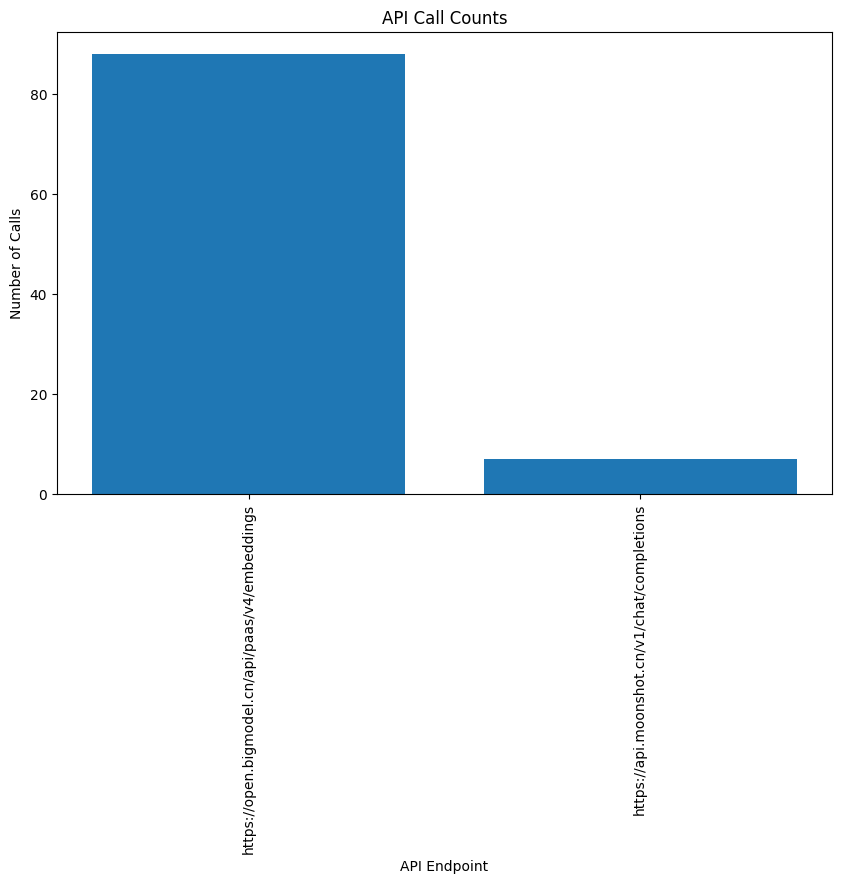

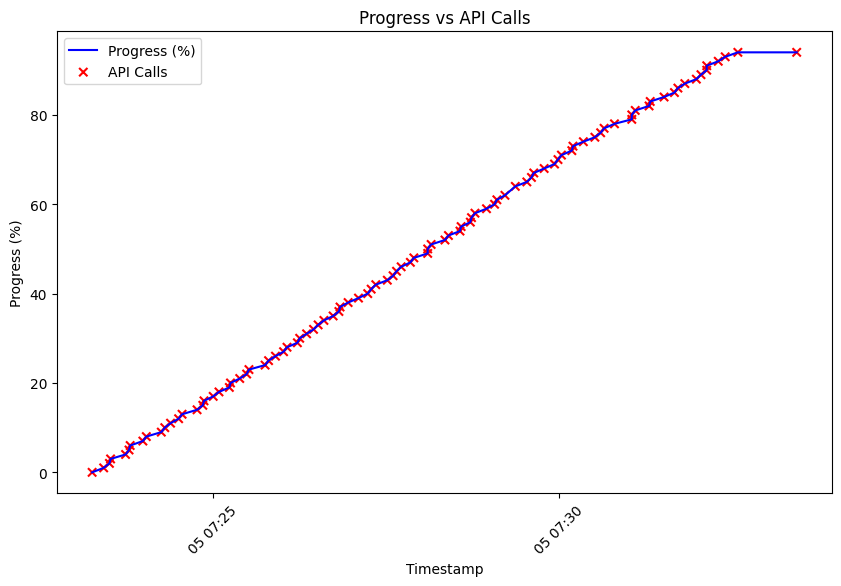

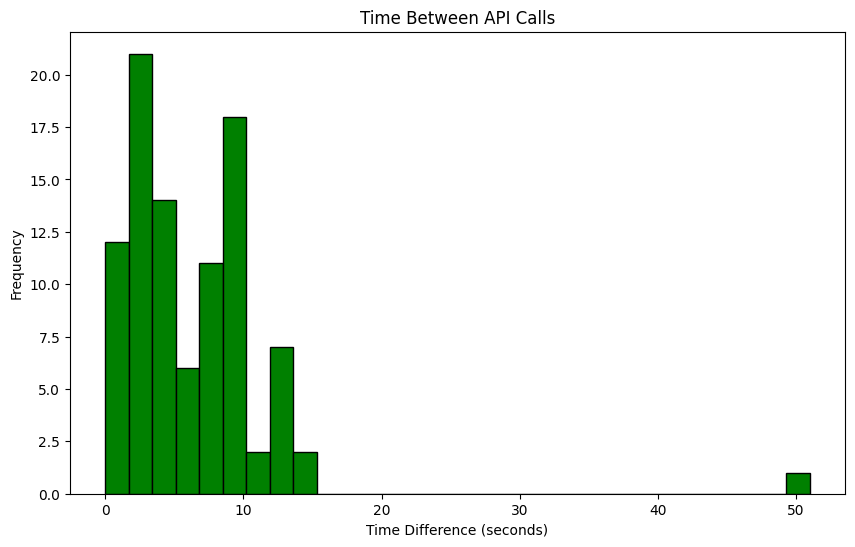

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

# 读取日志文件
log_file_path = '../Log/log.txt'

# 正则表达式：提取API请求、时间和进度
api_pattern = re.compile(r'POST (https?://\S+) "HTTP/1.1 200 OK"')
progress_pattern = re.compile(r'生成进度:\s*(\d+)%')
time_pattern = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})')

# 存储解析的数据
api_calls = []
timestamps = []
progress = []

# 读取文件并解析
with open(log_file_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    # 匹配API请求
    api_match = api_pattern.search(line)
    if api_match:
        api_calls.append(api_match.group(1))
    else:
        api_calls.append(None)  # 如果没有匹配到API，填充None
    
    # 匹配生成进度
    progress_match = progress_pattern.search(line)
    if progress_match:
        progress.append(int(progress_match.group(1)))
    else:
        progress.append(None)  # 如果没有匹配到进度，填充None
    
    # 匹配时间戳
    time_match = time_pattern.search(line)
    if time_match:
        timestamps.append(datetime.strptime(time_match.group(1), '%Y-%m-%d %H:%M:%S'))
    else:
        timestamps.append(None)  # 如果没有匹配到时间戳，填充None

# 去除None值的行，确保数据一致性
df = pd.DataFrame({
    'timestamp': timestamps,
    'api_call': api_calls,
    'progress': progress
})

# 删除包含None的行
df = df.dropna()

# 计算API调用次数
api_count = Counter(df['api_call'])

# 计算每次API调用之间的时间差
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

# 绘制API调用的可视化图

# 1. API调用次数分布
plt.figure(figsize=(10, 6))
api_count_df = pd.DataFrame(api_count.items(), columns=['API', 'Count'])
api_count_df = api_count_df.sort_values(by='Count', ascending=False)

plt.bar(api_count_df['API'], api_count_df['Count'])
plt.title('API Call Counts')
plt.xticks(rotation=90)
plt.xlabel('API Endpoint')
plt.ylabel('Number of Calls')
plt.show()

# 2. 进度条与API调用关系
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['progress'], label='Progress (%)', color='blue')
plt.scatter(df['timestamp'], df['progress'], c=df['api_call'].apply(lambda x: 'red' if x else 'blue'), label='API Calls', marker='x')
plt.title('Progress vs API Calls')
plt.xlabel('Timestamp')
plt.ylabel('Progress (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 3. API调用时间差分布
plt.figure(figsize=(10, 6))
plt.hist(df['time_diff'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Time Between API Calls')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()